In [1]:
#импорт библиотек
import numpy as np
import pandas as pd
#библиотеки для графиков
import seaborn as sns
import matplotlib.pyplot as plt
#библиотеки для модели
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
#считывание данных

nh3_2rh_25t = pd.read_excel('Данные для МО/NH3_100_200_300_500 ppm.xlsx', sheet_name='Untitled')
no2_2rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_ RH_2%.xlsx', sheet_name='Untitled')
no2_25rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_25%.xlsx', sheet_name='Untitled')
no2_50rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_50%.xlsx', sheet_name='Untitled')
no2_75rh_25t = pd.read_excel('Данные для МО/NO2_2_5_10 ppm_RH_75%.xlsx', sheet_name='Untitled')

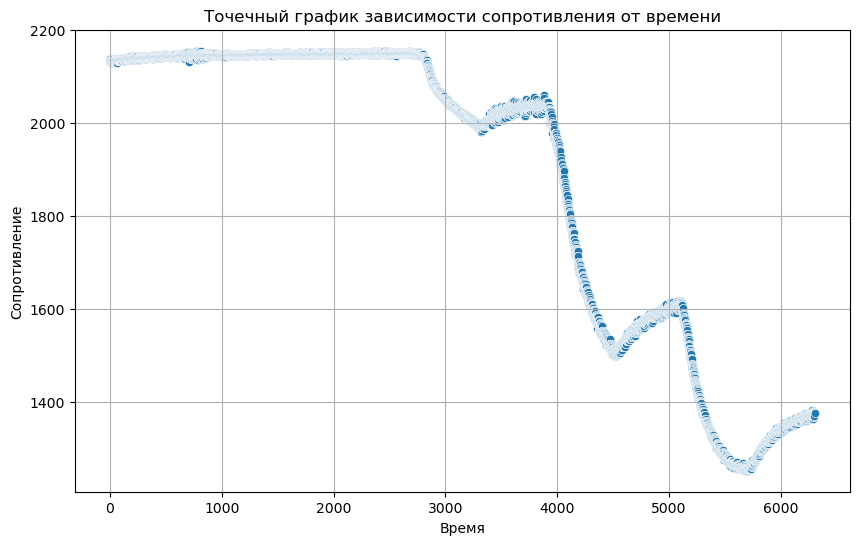

In [3]:
#строим график зависимости сопротивления от времени
def dependency_graphs(gas):
    gas = gas.iloc[1:]
    # Построим точечный график
    plt.figure(figsize=(10, 6))# размер графика
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas)# что и откуда берем

    plt.xlabel('Время')#ну как бы просто название
    plt.ylabel('Сопротивление')#название игрека
    plt.title('Точечный график зависимости сопротивления от времени')
    plt.grid(True)#добавим сеточку

    return plt.show()
dependency_graph = dependency_graphs(no2_25rh_25t)

In [4]:
#функция для обработки - добавим отдельный столбик с температурой(25), с относительнеой влажностью(для каждого файла она своя, но постоянная)
def temperature_and_RH(df,t,rh):
    df['temperature[°C]'] = t
    df['RH[%]']=rh
    return df

nh3_2rh_25t = temperature_and_RH(nh3_2rh_25t,25,2)
no2_2rh_25t = temperature_and_RH(no2_2rh_25t,25,2)
no2_25rh_25t = temperature_and_RH(no2_25rh_25t,25,25)
no2_50rh_25t = temperature_and_RH(no2_50rh_25t,25,50)
no2_75rh_25t = temperature_and_RH(no2_75rh_25t,25,75)
no2_75rh_25t

,R [Ом],Time [с],temperature[°C],RH[%]
0,0.000000,0.0,25,75
1,1662.937744,0.5,25,75
2,1663.950073,1.0,25,75
3,1666.321777,1.5,25,75
4,1664.376953,2.0,25,75
...,...,...,...,...
12595,1599.931519,6300.0,25,75
12596,1603.424072,6300.5,25,75
12597,1602.138062,6301.0,25,75
12598,1600.826782,6301.5,25,75


In [5]:
# #ЗДЕСЬ ВОЗНИКАЮТ НАНЫ, ЛИБО ПО-ДРУГОМУ ПЕРЕСЧИТАТЬ, ЛИБО ПРИДУМАТЬ КАК ИЗБАВЛЯТЬСЯ ОТ НАНОВ
# #ДОСТАТОЧНО МНОГО НУЛЕЙ ПОЯВЛЯЕТСЯ В СТОЛБЦЕ ПЕРИОДА 
# #функция для вычисления sin_time и cos_time (период где-то 1000с?) по крайней мере у аммиака
def sin_time_and_cos_time(df, time_column,R_column):
    df['period'] = df[R_column].diff()
    #print((df['period'] == 0).sum())
    #чтобы не появлялось нанов в столбцах с косинусом и синусом
    df.dropna(subset=['period'], inplace=True)

    df['sin_time'] = np.sin(2 * np.pi * df[time_column] / df['period'])
    df['cos_time'] = np.cos(2 * np.pi * df[time_column] / df['period'])
#удаляем временный столбец 'period'
    df.drop('period', axis=1, inplace=True)
    return df

nh3_2rh_25t = sin_time_and_cos_time(nh3_2rh_25t,'Time [с]','R [Ом]')
no2_2rh_25t  = sin_time_and_cos_time(no2_2rh_25t,'Time [с]','R [Ом]')
no2_25rh_25t = sin_time_and_cos_time(no2_25rh_25t,'Time [с]','R [Ом]')
no2_50rh_25t = sin_time_and_cos_time(no2_50rh_25t,'Time [с]','R [Ом]')
no2_75rh_25t = sin_time_and_cos_time(no2_75rh_25t,'Time [с]','R [Ом]')
nh3_2rh_25t


c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\katya\anaconda3\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in cos
  r

,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time
1,1916.370361,0.5,25,2,0.001639,0.999999
2,1917.799194,1.0,25,2,-0.950807,-0.309783
3,1914.129395,1.5,25,2,-0.542486,-0.840065
4,1916.431519,2.0,25,2,-0.734267,0.678860
5,1915.614380,2.5,25,2,-0.364946,0.931029
...,...,...,...,...,...,...
12595,1980.580811,6300.0,25,2,-0.663123,-0.748511
12596,1982.384766,6300.5,25,2,-0.605933,-0.795516
12597,1980.985718,6301.0,25,2,0.985290,0.170888
12598,1981.931763,6301.5,25,2,-0.643339,0.765581


In [6]:
#удаляем наны в датафрейме, а точнее заменяем их на предыдущее значение
nh3_2rh_25t.fillna(method = "ffill", inplace=True)

C:\Users\katya\AppData\Local\Temp\ipykernel_9504\1646652536.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  nh3_2rh_25t.fillna(method = "ffill", inplace=True)


In [7]:
#проверка на отсутствие нанов
nh3_2rh_25t.isnull().sum()

R [Ом]             0
Time [с]           0
temperature[°C]    0
RH[%]              0
sin_time           0
cos_time           0
dtype: int64

In [8]:
no2_2rh_25t.fillna(method = "ffill", inplace=True)

C:\Users\katya\AppData\Local\Temp\ipykernel_9504\1190838451.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  no2_2rh_25t.fillna(method = "ffill", inplace=True)


In [9]:
no2_2rh_25t.isnull().sum()

R [Ом]             0
Time [с]           0
temperature[°C]    0
RH[%]              0
sin_time           0
cos_time           0
dtype: int64

In [10]:
#нормализуем наши данные
def normalization(df):
    x_min = min(df['R [Ом]'])
    x_max = max(df['R [Ом]'])
    t_max = max(df['Time [с]'])
    t_min = min(df['Time [с]'])
    df['R [Ом]'] = (df['R [Ом]'] - x_min)/(x_max - x_min)#обычная мин макс
    df['Time [с]'] = (df['Time [с]'] - t_min)/(t_max - t_min)
    return df

nh3_2rh_25t = normalization(nh3_2rh_25t)
no2_2rh_25t = normalization(no2_2rh_25t)
no2_25rh_25t = normalization(no2_25rh_25t)
no2_50rh_25t = normalization(no2_50rh_25t)
no2_75rh_25t = normalization(no2_75rh_25t)
no2_25rh_25t


,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time
1,0.976020,0.000000,25,25,0.971805,-0.235785
2,0.976841,0.000079,25,25,0.812168,-0.583424
3,0.973840,0.000159,25,25,0.329640,-0.944107
4,0.972329,0.000238,25,25,-0.212016,-0.977266
5,0.975716,0.000317,25,25,-0.911741,0.410765
...,...,...,...,...,...,...
12590,0.134770,0.999683,25,25,0.633208,0.773982
12591,0.135192,0.999762,25,25,-0.974155,-0.225882
12592,0.128938,0.999841,25,25,-0.218528,-0.975831
12593,0.130088,0.999921,25,25,-0.895782,-0.444494


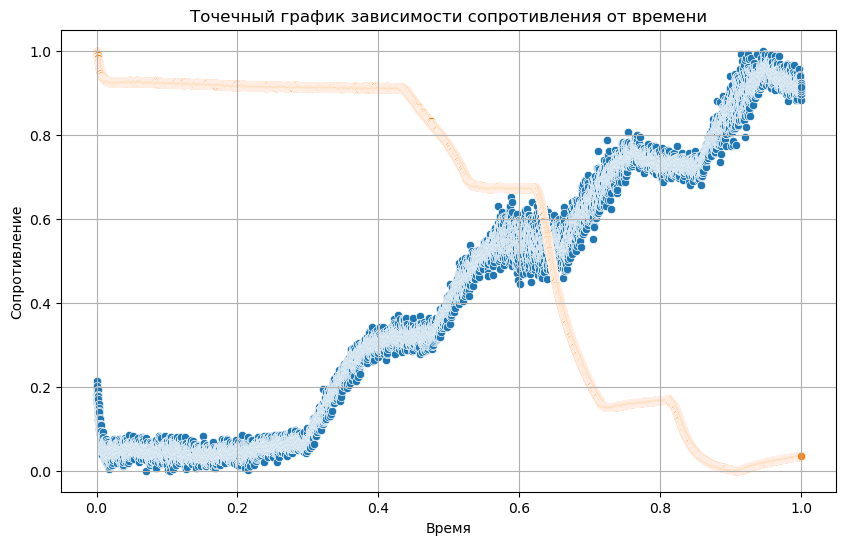

In [11]:
#проверим. что при нормализации ничего толком не поменялось
def dependency_graphs(gas1, gas2):
    gas1 = gas1.iloc[1:]
    gas2 = gas2.iloc[1:]
    # Построим точечный график
    plt.figure(figsize=(10, 6))# размер графика
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas1)# что и откуда берем
    sns.scatterplot(x='Time [с]', y='R [Ом]', data=gas2)

    plt.xlabel('Время')#ну как бы просто название
    plt.ylabel('Сопротивление')#название игрека
    plt.title('Точечный график зависимости сопротивления от времени')
    plt.grid(True)#добавим сеточку

    return plt.show()
dependency_graph = dependency_graphs(nh3_2rh_25t, no2_2rh_25t)

Ну что ж после нормализации данные\тренд не поменялись


### Теперь добавим целевую переменную

In [12]:
def target(df,value):
    df['y'] = value
    return df

nh3_2rh_25t = target(nh3_2rh_25t,1)
no2_2rh_25t = target(no2_2rh_25t,0)
no2_25rh_25t = target(no2_25rh_25t,0)
no2_50rh_25t = target(no2_50rh_25t,0)
no2_75rh_25t = target(no2_75rh_25t,0)

no2_2rh_25t.isnull()

,R [Ом],Time [с],temperature[°C],RH[%],sin_time,cos_time,y
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
12595,False,False,False,False,False,False,False
12596,False,False,False,False,False,False,False
12597,False,False,False,False,False,False,False
12598,False,False,False,False,False,False,False


In [13]:
# #разделим выборки на валидационную обучающую и тестовую
# train_size_nh3 = int(0.8 * len(nh3_2rh_25t))
# val_size_nh3 = int(0.1 * len(nh3_2rh_25t))
# test_size_nh3 = len(nh3_2rh_25t) - train_size_nh3 - val_size_nh3

# train_nh3 = nh3_2rh_25t[:train_size_nh3]
# val_nh3 = nh3_2rh_25t[train_size_nh3:train_size_nh3 + val_size_nh3]
# test_nh3 = nh3_2rh_25t[train_size_nh3 + val_size_nh3:]

# print("Обучающий набор:(длина)", len(train_nh3))
# print("Валидационный набор:", len(val_nh3))
# print("Тестовый набор:", len(test_nh3))


In [14]:
# #no2_2rh
# train_size_no2_2rh = int(0.8 * len(no2_2rh_25t))
# val_size_no2_2rh = int(0.1 * len(no2_2rh_25t))
# test_size_no2_2rh = len(no2_2rh_25t) - train_size_no2_2rh - val_size_no2_2rh

# train_no2_2rh = no2_2rh_25t[:train_size_no2_2rh]
# val_no2_2rh = no2_2rh_25t[train_size_no2_2rh:train_size_no2_2rh + val_size_no2_2rh]
# test_no2_2rh = no2_2rh_25t[train_size_no2_2rh + val_size_no2_2rh:]

# print("Обучающий набор:(длина)", len(train_no2_2rh))
# print("Валидационный набор:", len(val_no2_2rh))
# print("Тестовый набор:", len(test_no2_2rh))

In [15]:
# # Отделим целевую переменную каждого датафрейма в список
# target_nh3 = train_nh3['y'].tolist()
# target_no2_2rh = train_no2_2rh['y'].tolist()
# print(len(target_nh3))
# print(len(target_no2_2rh))

# #теперь избавимся от столбца y
# train_nh3_no_y = train_nh3.drop('y', axis = 1)
# train_no2_2rh_no_y = train_no2_2rh.drop('y', axis = 1)

# #Преобразуем теперь наши данные в X_train(но еще не до конца)
# def dataframe_to_list_of_lists(df):
#     """Преобразует датафрейм в список списков, где каждый внутренний список представляет строку датафрейма"""
#     list_of_lists = []
#     for _, row in df.iterrows():
#         list_of_lists.append(row.tolist())
#     return list_of_lists

# X_train_nh3 = dataframe_to_list_of_lists(train_nh3_no_y)
# X_train_no2_2rh = dataframe_to_list_of_lists(train_no2_2rh_no_y)
# X_train_no2_2rh


In [16]:
##############ДЛЯ ТРЭЙН ТЕСТА###########################
common_data = pd.concat([nh3_2rh_25t,no2_2rh_25t], ignore_index=True)
common_data
# Отделим целевую переменную в список

target_data = common_data['y'].tolist()

#теперь избавимся от столбца y
common_data_no_y = common_data.drop('y', axis = 1)

#Преобразуем теперь наши данные в X_train(но еще не до конца)
def dataframe_to_list_of_lists(df):
    """Преобразует датафрейм в список списков, где каждый внутренний список представляет строку датафрейма"""
    list_of_lists = []
    for _, row in df.iterrows():
        list_of_lists.append(row.tolist())
    return list_of_lists

X_data = dataframe_to_list_of_lists(common_data_no_y)
X_data

[[0.18542760751602233,
  0.0,
  25.0,
  2.0,
  0.0016393445180741069,
  0.9999986562738727],
 [0.20140215741721348,
  7.934618741569468e-05,
  25.0,
  2.0,
  -0.9508073898608804,
  -0.30978267767249323],
 [0.16037328995206954,
  0.00015869237483138936,
  25.0,
  2.0,
  -0.5424856504063892,
  -0.8400650683745616],
 [0.18611135373562904,
  0.00023803856224708403,
  25.0,
  2.0,
  -0.7342673820726751,
  0.6788603771204651],
 [0.17697563079341858,
  0.0003173847496627787,
  25.0,
  2.0,
  -0.36494572562914385,
  0.931028795121299],
 [0.19108182026618337,
  0.0003967309370784734,
  25.0,
  2.0,
  0.694969261531932,
  -0.7190394464323645],
 [0.18369299385310783,
  0.00047607712449416806,
  25.0,
  2.0,
  -0.9587015408846493,
  -0.2844140564483393],
 [0.190237032022797,
  0.0005554233119098627,
  25.0,
  2.0,
  -0.8646023566326752,
  0.5024567293859485],
 [0.1937540260505945,
  0.0006347694993255574,
  25.0,
  2.0,
  0.9408683797736256,
  -0.3387723305439106],
 [0.16832712821128715,
  0.00071

In [17]:
# Отделим целевую переменную датафрейма в список(no2_75rh)
y_test_no2_75rh = no2_75rh_25t['y'].tolist()

#теперь избавимся от столбца y
test_no2_75rh_no_y = no2_75rh_25t.drop('y', axis = 1)

X_test_no2_75rh = dataframe_to_list_of_lists(test_no2_75rh_no_y)

In [18]:
# Отделим целевую переменную датафрейма в список(no2_25rh)
y_test_no2_25rh = no2_25rh_25t['y'].tolist()

#теперь избавимся от столбца y
test_no2_25rh_no_y = no2_25rh_25t.drop('y', axis = 1)

X_test_no2_25rh = dataframe_to_list_of_lists(test_no2_25rh_no_y)

In [19]:
# Отделим целевую переменную датафрейма в список(no2_50rh)
y_test_no2_50rh = no2_50rh_25t['y'].tolist()

#теперь избавимся от столбца y
test_no2_50rh_no_y = no2_50rh_25t.drop('y', axis = 1)

X_test_no2_50rh = dataframe_to_list_of_lists(test_no2_50rh_no_y)

In [20]:
# # target_nh3_val = val_nh3['y'].tolist()
# # target_no2_2rh_val = val_no2_2rh['y'].tolist()
# # print(len(target_nh3_val))
# # print(len(target_no2_2rh_val))
# # print(target_nh3_val)
# #теперь избавимся от столбца y
# test_nh3_no_y = test_nh3.drop('y', axis = 1)
# test_no2_2rh_no_y = test_no2_2rh.drop('y', axis = 1)

# test_nh3 = dataframe_to_list_of_lists(test_nh3_no_y)
# test_no2_2rh = dataframe_to_list_of_lists(test_no2_2rh_no_y)
# test_nh3

### Здесь теория по реккурентной сети

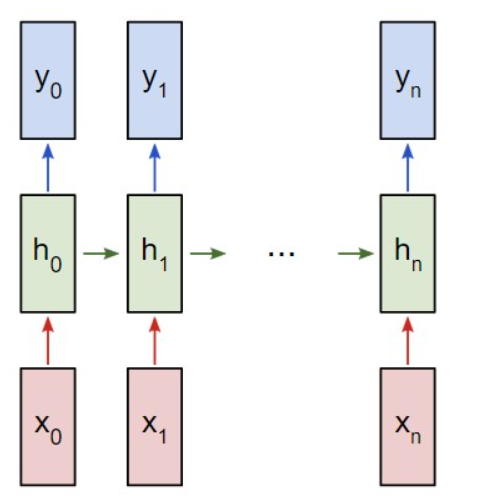

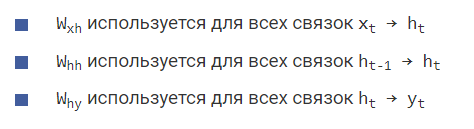

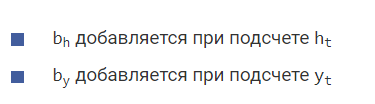

## Для функции forward

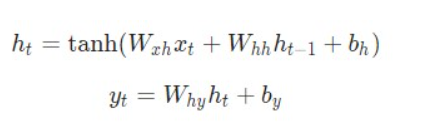

## Для функции backprop

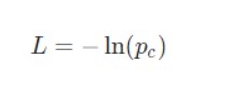

Если позитивный текст предсказывается как позитивный - то:

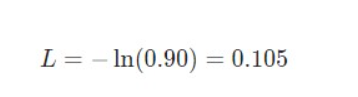

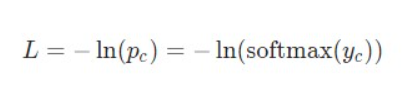

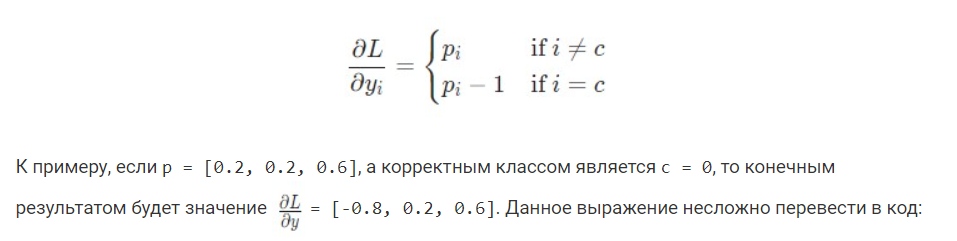

In [21]:
# # класс нейронной сети
# class MyRNN:
#     def __init__(self, input_size, hidden_size, output_size, learning_rate=0.02):
#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.output_size = output_size
#         self.learning_rate = learning_rate

#         # создаем матрицу, размером hidden_size и input_size, которые распр по норм закону
#         self.Wxh = np.random.randn(hidden_size, input_size) * 0.001
#         self.Whh = np.random.randn(hidden_size, hidden_size) * 0.001
#         self.Why = np.random.randn(output_size, hidden_size) * 0.001

#         # смещения, вектора из 0
#         self.bh = np.zeros((hidden_size, 1))
#         self.by = np.zeros((output_size, 1))

#     def forward(self, inputs):
#         """Прямое распространение"""
#         # инициализируем h
#         h = np.zeros((self.hidden_size, 1))  # вектор из 0 dim = размерность скрытого слоя разм-ть (n,1)

#         self.last_inputs = inputs  # сохранение входной последовательности(исп для backward)
#         self.last_hs = {0: h}  # словарь со скрытыми состояниями сети ключ - номер вр шага, значение - вектрр

#         for i, x in enumerate(inputs):
#             x = np.array(x).reshape(-1, 1)  # Преобразуем в вектор-столбец
#             h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)  # вычисляем h
#             self.last_hs[i + 1] = h  # сохраняем новое скрытое состояние
#         y = self.Why @ h + self.by  # вычисляем y
#         return y, h

#     def backprop(self, dy):
#         """Обратное распространение"""
#         n = len(self.last_inputs)  # длина нашей входной последовательности

#         dWhy = dy @ self.last_hs[n].T  # град функции потерь по весам, соед скрыт и выходной слой
#         dby = dy  # градиент по смещению выходного слоя - град по выходу
#         # инициализируем еще некоторые штуки
#         dWhh = np.zeros_like(self.Whh)
#         dWxh = np.zeros_like(self.Wxh)
#         dbh = np.zeros_like(self.bh)
#         # градиент ошибки по скрыт сост на посл временном шаге, обратное распр ошибки из вых слоя в скрытый
#         dh = self.Why.T @ dy  # dL/dh для последнего h

#         for t in reversed(range(n)):

#             dh_next = dh
#             # dL/dh * (1 - h^2)
#             dh_next = dh_next * (1 - self.last_hs[t + 1] ** 2)
#             # dL/db = dL/dh * (1 - h^2)
#             dbh += dh_next
#             # dL/dWhh = dL/dh * (1 - h^2) * h_{t-1}
#             dWhh += dh_next @ self.last_hs[t].T
#             # dL/dWxh = dL/dh * (1 - h^2) * x
#             dWxh += dh_next @ self.last_inputs[t].reshape(self.input_size, 1).T
#             # След dL/dh = dL/dh * (1 - h^2) * Whh
#             dh = self.Whh.T @ dh_next
#         # обновляем веса используя градиентный спуск
#         self.Whh -= self.learning_rate * dWhh
#         self.Wxh -= self.learning_rate * dWxh
#         self.Why -= self.learning_rate * dWhy
#         self.bh -= self.learning_rate * dbh
#         self.by -= self.learning_rate * dby

#     def predict(self, inputs):
#         """Предсказание результата после прямого прохода"""
#         y, _ = self.forward(inputs)  # отсюда берем только y
#         return np.argmax(self.softmax(y))

#     def softmax(self, x):
#         """Функция активации"""
#         e_x = np.exp(x - np.max(x))  # для предотвращения переполнения
#         return e_x / e_x.sum(axis=0)

#     def train(self, X_train, y_train, epochs=10, print_interval=1):
#         """Функция обучения с выводом через заданный интервал эпох"""
#         for epoch in range(epochs):
#             epoch_loss = 0  # переменная для накопления ошибки
#             correct_predictions = 0  # количество правильных предсказаний
#             tp = 0
#             fp = 0
#             fn = 0
#             tn = 0
#             total_predictions = 0  # количество предсказаний всего

#             for _, (x, y) in enumerate(zip(X_train, y_train)):  # идем по попарно объединенным X_train и y_train
#                 x = np.array(x).reshape(-1,1) #важно!
#                 y = np.array([y])  # он если что одномерный

#                 y_pred, _ = self.forward(x)  # y_pred - результат прямой проходки
#                 loss = -np.sum((y * np.log(y_pred) + (1-y)*np.log(1-y_pred)))  # MSE - среднеквадратичная ошибка
#                 dy = 2 * (y_pred - y)  # градиент функции потерь

#                 self.backprop(dy)  # теперь используем обратное распространение
#                 epoch_loss -= loss  # прибавляем значение ошибки
#                 predicted_class = self.predict(x)  # предсказание для текущего

#                 # Подсчет TP, TN, FP, FN. Предполагается бинарная классификация (0 или 1).
#                 if y[0] == 1 and predicted_class == 1:
#                     tp += 1
#                 elif y[0] == 1 and predicted_class == 0:
#                     fn += 1
#                 elif y[0] == 0 and predicted_class == 1:
#                     fp += 1
#                 elif y[0] == 0 and predicted_class == 0:
#                     tn += 1

#                 correct_predictions += int(predicted_class == y[0])  # увеличиваем, если класс совпал с целевым
#                 total_predictions += 1

#             accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0  # accuracy за одну эпоху
#             precision = tp / (tp + fp) if (tp + fp) > 0 else 0
#             recall = tp / (tp + fn) if (tp + fn) > 0 else 0

#             # Вывод результатов через заданный интервал
#             if (epoch + 1) % print_interval == 0 or epoch == epochs - 1:  # Выводим на последней эпохе всегда.
#                 print(f"Epoch {epoch + 1}/{epochs}, loss: {epoch_loss}, accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")
#                 print(f"Correct_predictions = {correct_predictions}, total_predictions = {total_predictions}")
#                 print(total_predictions)
#         # Вычисление общих метрик ПОСЛЕ цикла
#         #overall_accuracy = total_correct_predictions / total_predictions if total_predictions > 0 else 0
#         # overall_precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
#         # overall_recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
#        # print(f"\nОбщая точность: {overall_accuracy:.4f}")


In [22]:
# #Пробуем использовать

# input_size = 1 #
# hidden_size = 25#пока что номер от балды, думаю его можно пробовать менять
# output_size = 2#выводит вероятность принадлежности к положительном классу

# simple_rnn = MyRNN(input_size, hidden_size,output_size)

# X_train = X_train_nh3 + X_train_no2_2rh
# print (f"Длина X_train: {len(X_train)}")
# X_train

# X_val = X_val_nh3 + X_val_no2_2rh
# print(f"Длина X_val: {len(X_val)}")

# y_train = target_nh3 + target_no2_2rh
# print (f"Длина y_train: {len(y_train)}")
# #print(y_train)

# y_val = target_nh3_val + target_no2_2rh_val
# print(f"Длина y_val: {len(y_val)}")

# simple_rnn.train(X_train,y_train)

# #simple_rnn.train(X_val,y_val)
# y_train = target_nh3 + target_no2_2rh
# print(y_train)

In [23]:
# Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X_data, target_data, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

print(f"Размер тренировочной выборки: {len(X_train)}")
print(f"Размер валидационной выборки: {len(X_val)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер тренировочной выборки: 20158
Размер валидационной выборки: 2520
Размер тестовой выборки: 2520


In [30]:
# Преобразование данных в тензоры PyTorch
x_train_tensor = torch.tensor(X_train, dtype=torch.float32)# из нумпая в тензор, данные как float32 
y_train_tensor = torch.tensor(y_train, dtype=torch.long) #long -  для классификации(указывает типа, что это прям переменные класса именно, а не просто признаки)


x_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)


# Модель RNN
class SimpleRNN(nn.Module):#базовый модуль для всех нейронок библиотеки
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()# конструктор из класса-родителя, для инициализации
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)#dim батча - первая размерность входного тензора
        self.fc = nn.Linear(hidden_size, output_size)#полностью связанный слой, используется для преобразования скрытого состояния в выходной вектор
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #Создаем тензор нулей, начальное скрытое состояние (h0)
        #1: dim, соответствующая направлению RNN (в данном случае - 1, так как RNN не двунаправленный)
        #x.size(0): Размер батча (количество примеров в батче)
        #self.hidden_size: Размер скрытого состояния
        h0 = torch.zeros(1, x.size(0), self.hidden_size)# Инициализация hidden state, важное изменение для batch_first=True
        out, hn = self.rnn(x, h0) #hn - последнее скрытое состояние, out - выход rnn содержит скрытое состояние на каждом временном шаге
        out = self.fc(out[:, -1, :]) #все элементы батча, посл вр шаг, все знач скрыт. сост.
        out = self.sigmoid(out)
        return out

# Гиперпараметры
input_size = 6# количество элементов в каждом подмассиве нашего массива
hidden_size = 16# подбираем сами, такое количество вполне норм сейчас
output_size = 1# выходной слой
learning_rate = 0.01# размер шага для нашего алгоритма оптимизации
epochs = 200
batch_size = len(X_train)#соответствует длине данных, В ОБЩЕМ СЛУЧАЕ ЛУЧШЕ ЧУТЬ ПОДПРАВИТЬ ЭТО


model = SimpleRNN(input_size, hidden_size, output_size)
criterion = nn.BCELoss() # Бинарная кросс-энтропия
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение
for epoch in range(epochs):
    optimizer.zero_grad()#сбрасываем градиенты оптимизатора до нуля, иначе с расчетом весов будет проблема
    outputs = model(x_train_tensor.unsqueeze(1)) # Добавляем дополнительную размерность для времени
    loss = criterion(outputs.squeeze(1), y_train_tensor.float()) # Снимаем лишнее измерение
    loss.backward()
    optimizer.step()#обновляем веса модели
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            train_predictions = (model(x_train_tensor.unsqueeze(1)) > 0.5).float()
            train_accuracy = accuracy_score(y_train_tensor.numpy(), train_predictions.squeeze(1).numpy())

            # Оценка на валидационных данных
            val_predictions = (model(x_val_tensor.unsqueeze(1)) > 0.5).float()
            val_loss = criterion(val_predictions.squeeze(1), y_val_tensor.float())
            val_accuracy = accuracy_score(y_val_tensor.numpy(), val_predictions.squeeze(1).numpy())

            print(f'Epoch [{epoch+1}/{epochs}], '
                  f'Loss: {loss.item():.4f}, Accuracy: {train_accuracy:.4f}, '
                  f'Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')


#Оценка точности после обучения
with torch.no_grad():
    predictions = (model(x_train_tensor.unsqueeze(1)) > 0.5).float()
    accuracy = accuracy_score(y_train_tensor.numpy(), predictions.squeeze(1).numpy())
    print(f'\nTrain Accuracy: {accuracy:.4f}')

with torch.no_grad():
    final_val_predictions = (model(x_val_tensor.unsqueeze(1)) > 0.5).float()
    final_val_accuracy = accuracy_score(y_val_tensor.numpy(), final_val_predictions.squeeze(1).numpy())
    print(f'\nValidation Accuracy: {final_val_accuracy:.4f}')


Epoch [10/200], Loss: 0.6941, Accuracy: 0.4981, Val Loss: 48.9683, Val Accuracy: 0.5103
Epoch [20/200], Loss: 0.6936, Accuracy: 0.5019, Val Loss: 51.0317, Val Accuracy: 0.4897
Epoch [30/200], Loss: 0.6916, Accuracy: 0.5736, Val Loss: 42.3413, Val Accuracy: 0.5766
Epoch [40/200], Loss: 0.6834, Accuracy: 0.5732, Val Loss: 44.0476, Val Accuracy: 0.5595
Epoch [50/200], Loss: 0.6728, Accuracy: 0.6203, Val Loss: 38.4921, Val Accuracy: 0.6151
Epoch [60/200], Loss: 0.6590, Accuracy: 0.6591, Val Loss: 34.1667, Val Accuracy: 0.6583
Epoch [70/200], Loss: 0.6397, Accuracy: 0.6599, Val Loss: 33.8095, Val Accuracy: 0.6619
Epoch [80/200], Loss: 0.6162, Accuracy: 0.6961, Val Loss: 30.5159, Val Accuracy: 0.6948
Epoch [90/200], Loss: 0.5905, Accuracy: 0.6756, Val Loss: 32.2619, Val Accuracy: 0.6774
Epoch [100/200], Loss: 0.5646, Accuracy: 0.6943, Val Loss: 30.8730, Val Accuracy: 0.6913
Epoch [110/200], Loss: 0.5402, Accuracy: 0.6882, Val Loss: 31.3095, Val Accuracy: 0.6869
Epoch [120/200], Loss: 0.5176,

In [25]:
#torch.save(model.state_dict(), 'model.pth')

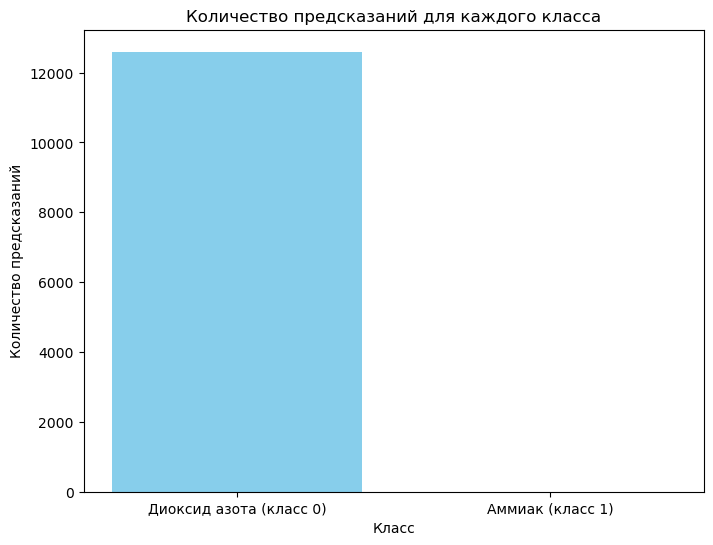

Вероятность принадлежности к классу аммиака: 0.008898152969777584 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.008914181031286716 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.010184337384998798 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.008949480950832367 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.00878982525318861 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.009051991626620293 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.009665368124842644 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.008988197892904282 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.008921661414206028 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.009518510662019253 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.009256890043616295 - это диоксид азота
Вероятность принадлежности к классу аммиака: 0.00887920

In [32]:
# Преобразование тестовых данных
x_test_tensor = torch.tensor(X_test_no2_75rh, dtype=torch.float32)
#y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Оценка на тестовой выборке
with torch.no_grad():
    test_outputs = model(x_test_tensor.unsqueeze(1))
    test_predictions = (test_outputs > 0.5).float()
    #test_accuracy = accuracy_score(y_test_tensor.numpy(), test_predictions.squeeze(1).numpy())

#print(f'Test Accuracy: {test_accuracy:.4f}')
# Подсчет количества предсказаний для каждого класса
class_counts = test_predictions.squeeze(1).numpy()
unique, counts = np.unique(class_counts, return_counts=True)
class_counts_dict = dict(zip(unique, counts))

# Построение графика
labels = ['Диоксид азота (класс 0)', 'Аммиак (класс 1)']
counts = [class_counts_dict.get(0.0,0), class_counts_dict.get(1.0,0)] #Обработка случая, если какого-то класса нет в предсказаниях

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['skyblue', 'lightcoral'])
plt.title('Количество предсказаний для каждого класса')
plt.ylabel('Количество предсказаний')
plt.xlabel('Класс')
plt.show()

nh3 = 0
no2 = 0
# Логика для вывода класса
for i, prob in enumerate(test_outputs.squeeze(1)):
    if prob.item() > 0.5:
        nh3+=1
        print(f"Вероятность принадлежности к классу аммиака: {prob.item()} - это аммиак")
    else:
        no2+=1
        print(f"Вероятность принадлежности к классу аммиака: {prob.item()} - это диоксид азота")
print(f"Количество предсказаний за аммиак: {nh3}")
print(f"Количество предсказаний за диоксид азота: {no2}")